In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [12]:
class Net_base(nn.Module):   
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self):
        pass
        
class Net_dense(Net_base):   
    def __init__(self, layers, activation = nn.Tanh, **kwargs):
        super().__init__(**kwargs)
        self.layers = layers
        self.num_layers = len(layers)
        self.activation = activation
        self.build()        
        
    def build(self):
        """Create the state of the layers (weights)"""                
        self.input_layer = nn.Sequential(*[
                        nn.Linear(self.layers[0], self.layers[1]),
                        self.activation()])
        
        self.hidden_layers = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(self.layers[i], self.layers[i+1]),
                            self.activation()]) for i in range(1, self.num_layers - 2)])
        
        self.output_layer = nn.Linear(self.layers[-2], self.layers[-1])
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x
    
    

    

In [19]:
net = Net_dense([3, 5, 5,1])

In [25]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
d, w0 = 2, 20
mu, k = 2*d, w0**2
dx0 = 0

x_data = torch.tensor([0.0])#x[0:200:20]
y_data = torch.tensor([1.0])

model = Net_dense([1, 32, 32, 1])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(50000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)#(1e-4)*torch.mean(physics**2)
    loss3 = (1e-1)*(dx0 - dx[0])**2

    
    # backpropagate joint loss
    loss = loss1 + loss2 + loss3 # add three loss terms together
    loss.backward()
    optimizer.step()


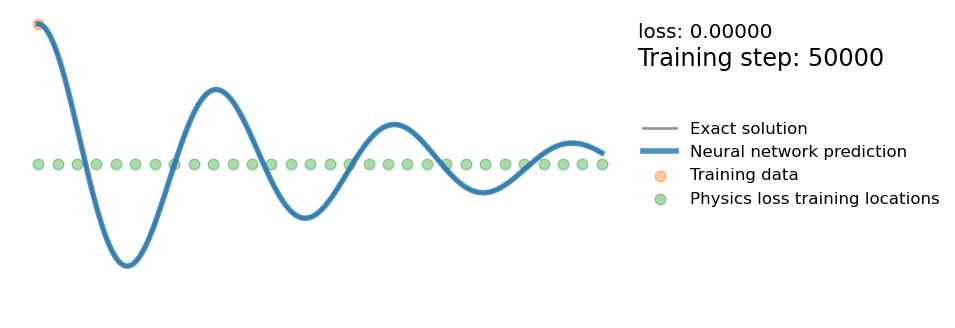

In [28]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.text(1.065,0.9,f"loss: {np.mean(((y-yh).numpy())**2):.5f}",fontsize="x-large",color="k")
    plt.axis("off")

x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
yh = model(x).detach()
xp = x_physics.detach()
        
plot_result(x,y,x_data,y_data,yh,xp)
        
